In [1]:
# Add folder to path in order to load from the check_packages.py script
import sys
sys.path.insert(0, "..")

In [2]:
import os
import json
import pandas as pd
import pathlib
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import BorderlineSMOTE

In [3]:
print(os.getcwd())
# Going up one directory from current (notebooks) to the project root
os.chdir("..")
print(os.getcwd())

C:\Users\Nene\iot_sensors_prediction_classification\notebooks
C:\Users\Nene\iot_sensors_prediction_classification


In [4]:
with open("config.json", "r") as file:
    config = json.load(file)

In [5]:
# Utility functions
def load_dataset(path):
    data = {}
    
    for folder in os.listdir(path):
        if folder == "Not using":
            continue
            
        cur_folder = pathlib.Path(os.path.join(path, folder))
        if not os.path.exists(cur_folder):
            print(f" Skipping '{condition}' (Not found)")
            continue

        all_files_path = list(cur_folder.glob("*.txt"))
        dfs = [] 
        for file_path in all_files_path:
            try:
                df = pd.read_csv(file_path, sep=None, engine="python")
                dfs.append(df)
            except Exception as e:
                print(f" Error reading '{file_path}': {e}")

        if dfs:
            data[folder]= pd.concat(dfs, ignore_index=True)

    return data


def merge_dataset(dataset):
    conditions = list(dataset.keys())
    combined_df = pd.concat([dataset[cond] for cond in conditions], ignore_index=True)


    return combined_df


def create_sequence(df, window_size=6,label_column=0):
    df_as_np = df.to_numpy()
    X = []
    y = []
    for i in range(len(df_as_np)-window_size):
        row = [r for r in df_as_np[i:i+window_size]]
        X.append(row)
        label = df_as_np[i+window_size][label_column]
        y.append(label)
    return np.array(X), np.array(y)


# EDA, Preprocessing and Feature Engineering for the CNN-LSTM System Data

In [6]:
data = load_dataset(config["inter_data_path"])

## EDAs

In [7]:
clean_data = data.get("clean")

In [8]:
print(len(clean_data))

201600


In [9]:
clean_data.head()

,timestamp,mote_id,has_fault_type,temperature,light
0,'2004-02-29T00:00:00',1,0,19.2600,45.08
1,'2004-02-29T00:00:30',1,0,19.2500,45.08
2,'2004-02-29T00:01:00',1,0,19.2500,45.08
3,'2004-02-29T00:01:30',1,0,19.2436,45.08
4,'2004-02-29T00:02:00',1,0,19.2400,45.08


In [10]:
clean_data.isna().sum()

timestamp         0
mote_id           0
has_fault_type    0
temperature       0
light             0
dtype: int64

In [11]:
# Removes leading and trailing whitespace, double quotes, single quotes
clean_data["timestamp"] = clean_data["timestamp"].str.strip().str.replace('"', '').str.replace("'", '')

In [12]:
# convert 'timestamp' to datetime
clean_data["timestamp"] = pd.to_datetime(clean_data.timestamp, format="%Y-%m-%dT%H:%M:%S") 

In [13]:
clean_data = clean_data.sort_values("timestamp").reset_index(drop=True)

In [14]:
# Check time intervals
clean_data["time_interval"] = clean_data.timestamp - clean_data.timestamp.shift(1)
clean_data[["timestamp", "time_interval"]].head()

,timestamp,time_interval
0,2004-02-29,NaT
1,2004-02-29,0 days
2,2004-02-29,0 days
3,2004-02-29,0 days
4,2004-02-29,0 days


In [15]:
print(clean_data["time_interval"].value_counts())

0 days 00:00:00    181440
0 days 00:00:30     20159
Name: time_interval, dtype: int64


In [16]:
# some added features just for visualization purpose
clean_data["temp_interval"] = clean_data.temperature - clean_data.temperature.shift(1)
clean_data["light_interval"] = clean_data.light - clean_data.light.shift(1)

In [17]:
start_date, end_date = clean_data["timestamp"].min(), clean_data["timestamp"].max()
print("Start Date:", start_date)
print("End Date:", end_date)
print("Time period:", end_date - start_date )

# we have 6days 23h+(aprox 7days) what of data, spaced at 30 seconds

Start Date: 2004-02-29 00:00:00
End Date: 2004-03-06 23:59:30
Time period: 6 days 23:59:30


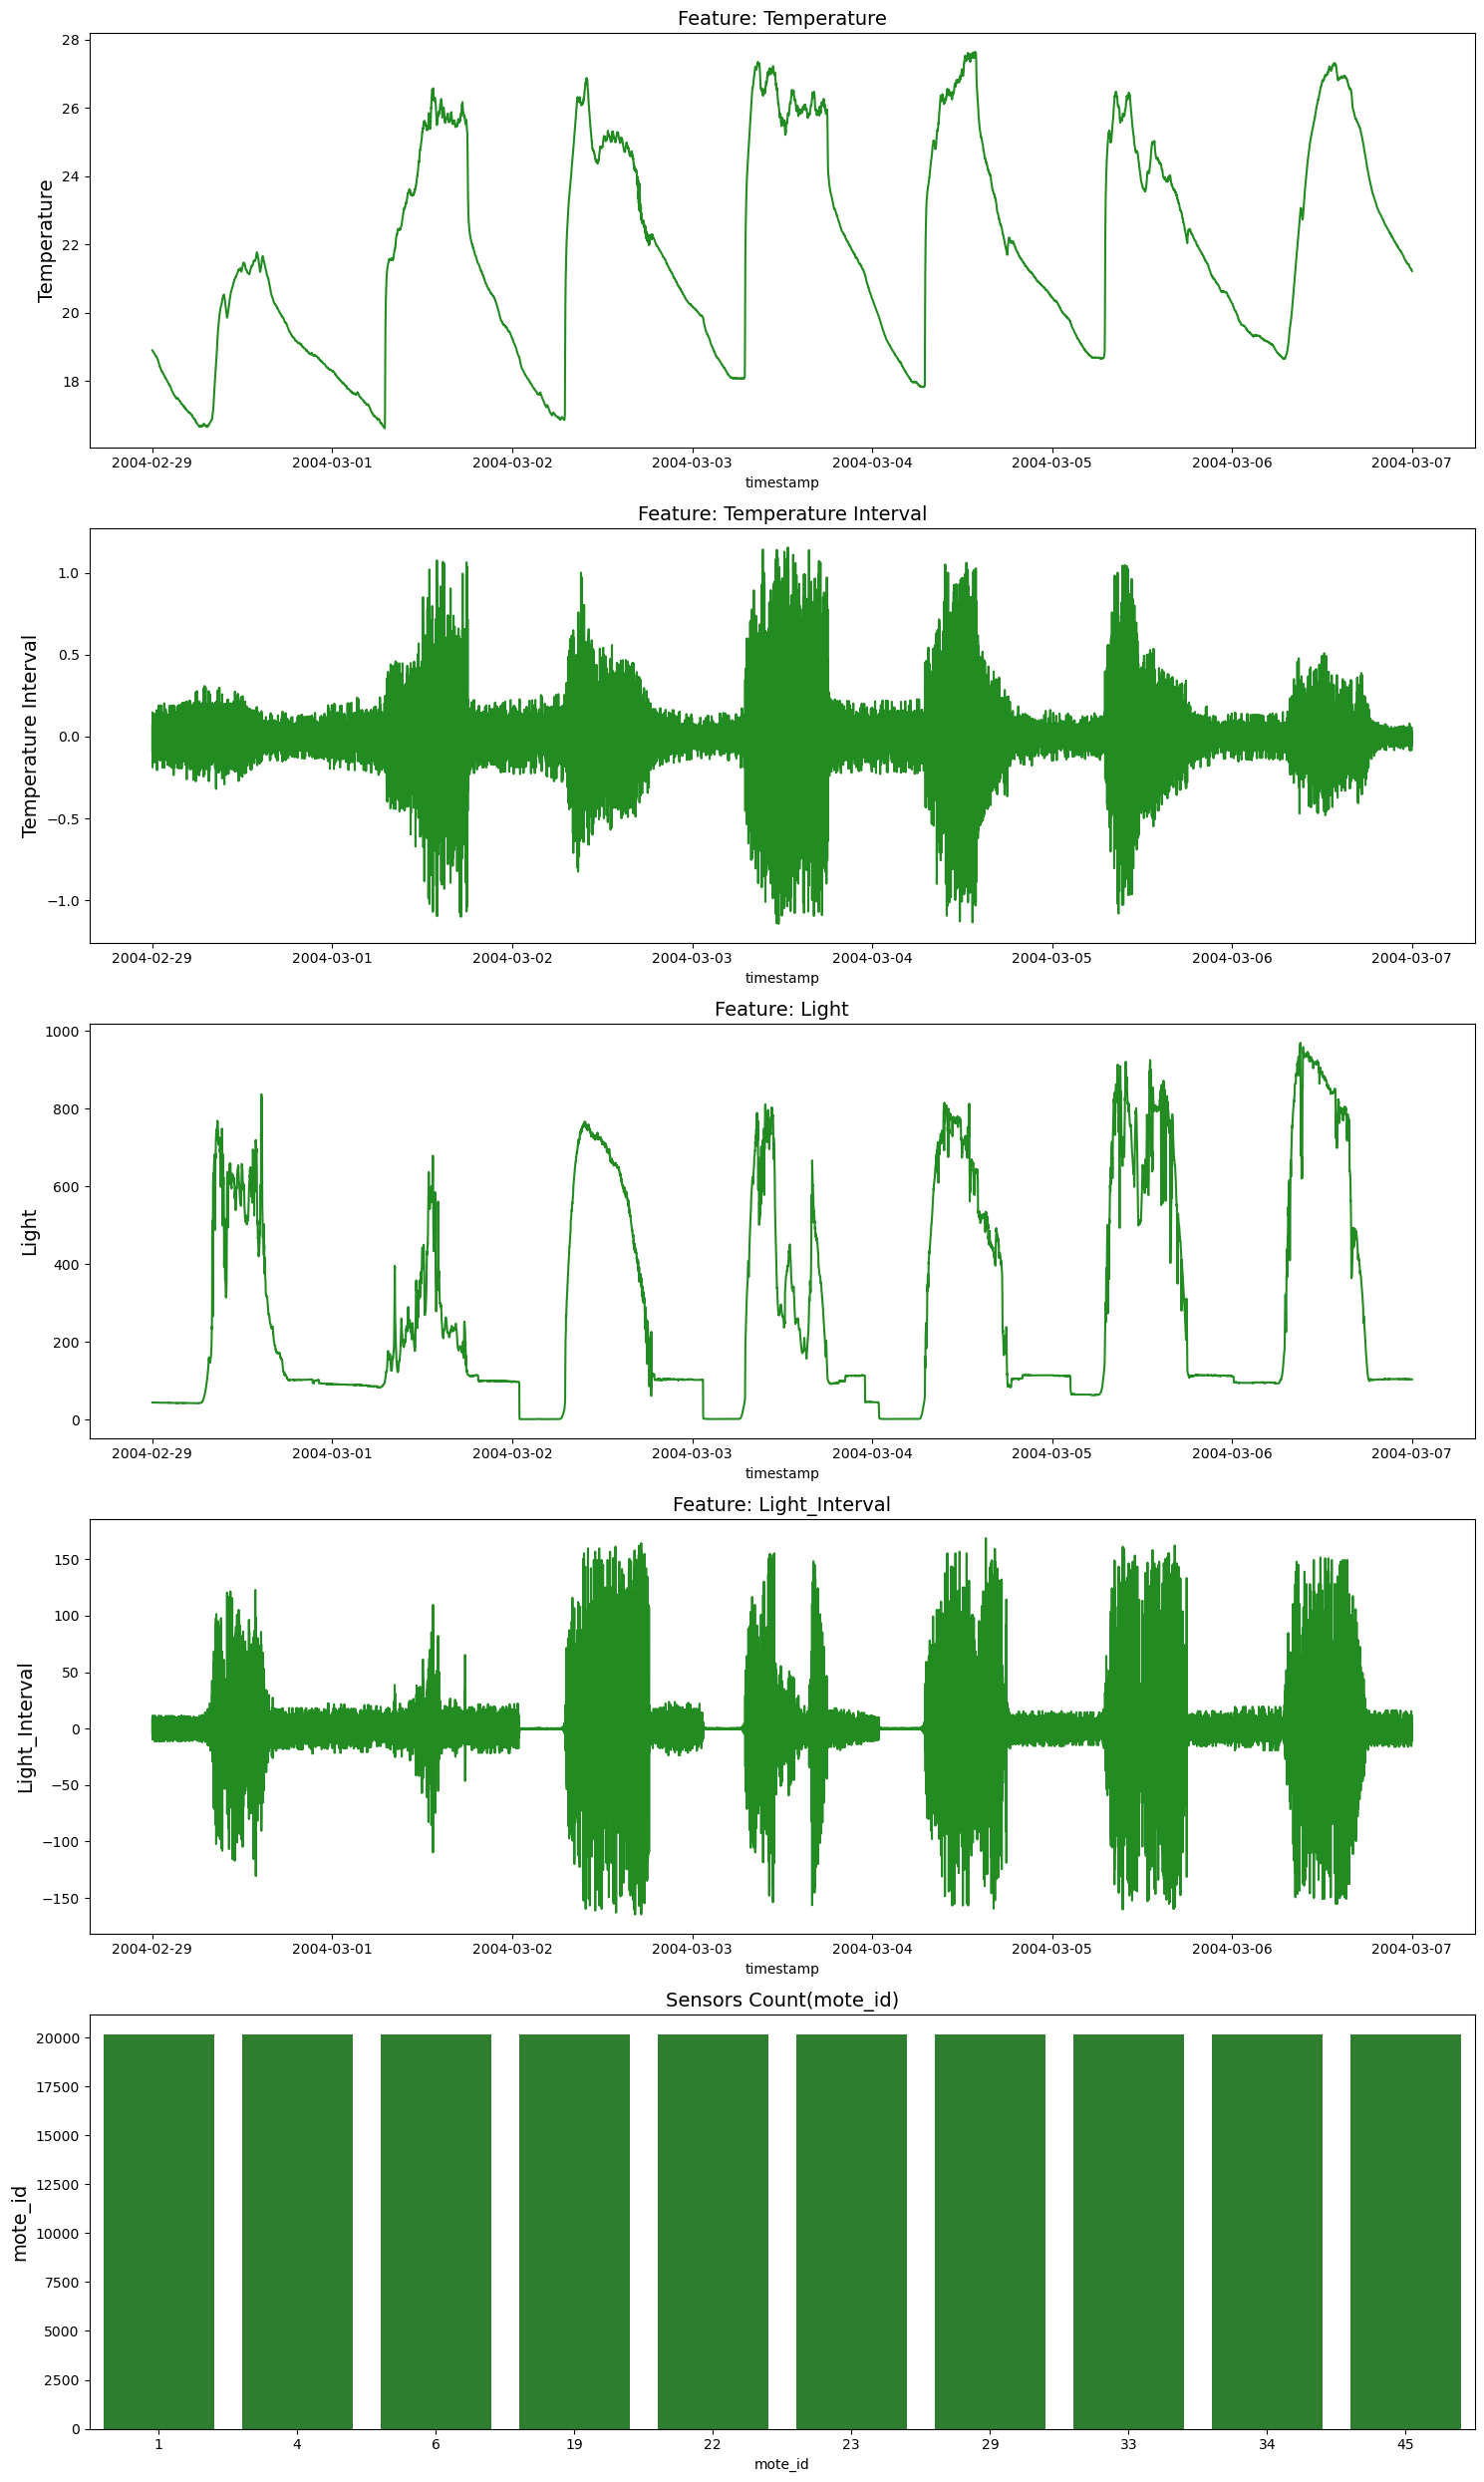

In [18]:
# Visualizing the dataset
fig, ax = plt.subplots(nrows=5, ncols=1, figsize=(15, 25))

sns.lineplot(x=clean_data.timestamp, y=clean_data.temperature.fillna(np.inf), ax=ax[0], color="forestgreen", ci=None)
ax[0].set_title("Feature: Temperature", fontsize=14)
ax[0].set_ylabel(ylabel= "Temperature", fontsize=14)


sns.lineplot(x=clean_data.timestamp, y=clean_data.temp_interval.fillna(0), ax=ax[1], color="forestgreen", ci=None)
ax[1].set_title("Feature: Temperature Interval", fontsize=14)
ax[1].set_ylabel(ylabel="Temperature Interval", fontsize=14)


sns.lineplot(x=clean_data.timestamp, y=clean_data.light.fillna(np.inf), ax=ax[2], color="forestgreen", ci=None)
ax[2].set_title("Feature: Light", fontsize=14)
ax[2].set_ylabel(ylabel="Light", fontsize=14)


sns.lineplot(x=clean_data.timestamp, y=clean_data.light_interval.fillna(0), ax=ax[3], color="forestgreen", ci=None)
ax[3].set_title("Feature: Light_Interval", fontsize=14)
ax[3].set_ylabel(ylabel="Light_Interval", fontsize=14)


sns.countplot(x=clean_data.mote_id, ax=ax[4], color="forestgreen")
ax[4].set_title("Sensors Count(mote_id)", fontsize=14)
ax[4].set_ylabel(ylabel="mote_id", fontsize=14)


# for i in range(4):
#     ax[i].set_xlim([datetime(2004, 3, 4, 0, 0, 0), datetime(2004, 3, 6, 23, 59, 30)])
    
plt.tight_layout()
plt.show()

In [19]:
clean_data.mote_id.value_counts()

1     20160
19    20160
45    20160
34    20160
29    20160
23    20160
33    20160
6     20160
4     20160
22    20160
Name: mote_id, dtype: int64

In [20]:
clean_data = clean_data[["timestamp", "temperature", "light"]]

## Preprocessing

In [21]:
clean_data.isna().sum()

timestamp      0
temperature    0
light          0
dtype: int64

#### Stationarity
 Time series with trend and/or seasonality are not stationary. 
 Trend indicates that the mean is not constant over time and seasonality indicates that the variance is not constant over time. 
 
 
**checking for:** 
- visually: if stationary, should following a Guasian distribution curve
- basic statistics: split time series and compare the mean and variance of each partition

In [22]:
partition1_mean = clean_data.iloc[:67200].mean(numeric_only=True)
partition1_var = clean_data.iloc[:67200].var(numeric_only=True)

partition2_mean = clean_data.iloc[67200:134400].mean(numeric_only=True)
partition2_var = clean_data.iloc[67200:134400].var(numeric_only=True)

partition3_mean = clean_data.iloc[134400:].mean(numeric_only=True)
partition3_var = clean_data.iloc[134400:].var(numeric_only=True)

stationarity_test = pd.concat([partition1_mean, partition2_mean,partition3_mean, partition1_var, 
                               partition2_var, partition3_var], axis=1)
stationarity_test.columns = ["Partition 1 Mean", "Partition 2 Mean","Partition 3 Mean", 
                             "Partition 1 Variance", "Partition 2 Variance", "Partition 3 Variance"]

stationarity_test

,Partition 1 Mean,Partition 2 Mean,Partition 3 Mean,Partition 1 Variance,Partition 2 Variance,Partition 3 Variance
temperature,20.010642,23.064954,22.314366,9.159688,14.060559,7.792247
light,186.241465,321.579720,342.607428,53952.989709,157957.173921,169754.627774


As observed from the basic statistics of the data, splited into three folds, the mean and variance vary across the partitions. This suggests that the temperature and light data do not appear to be stationary.

Next, we evaluate the histograms. If the data is stationary, it should approximately follow a Gaussian distribution (i.e., a bell-shaped curve).

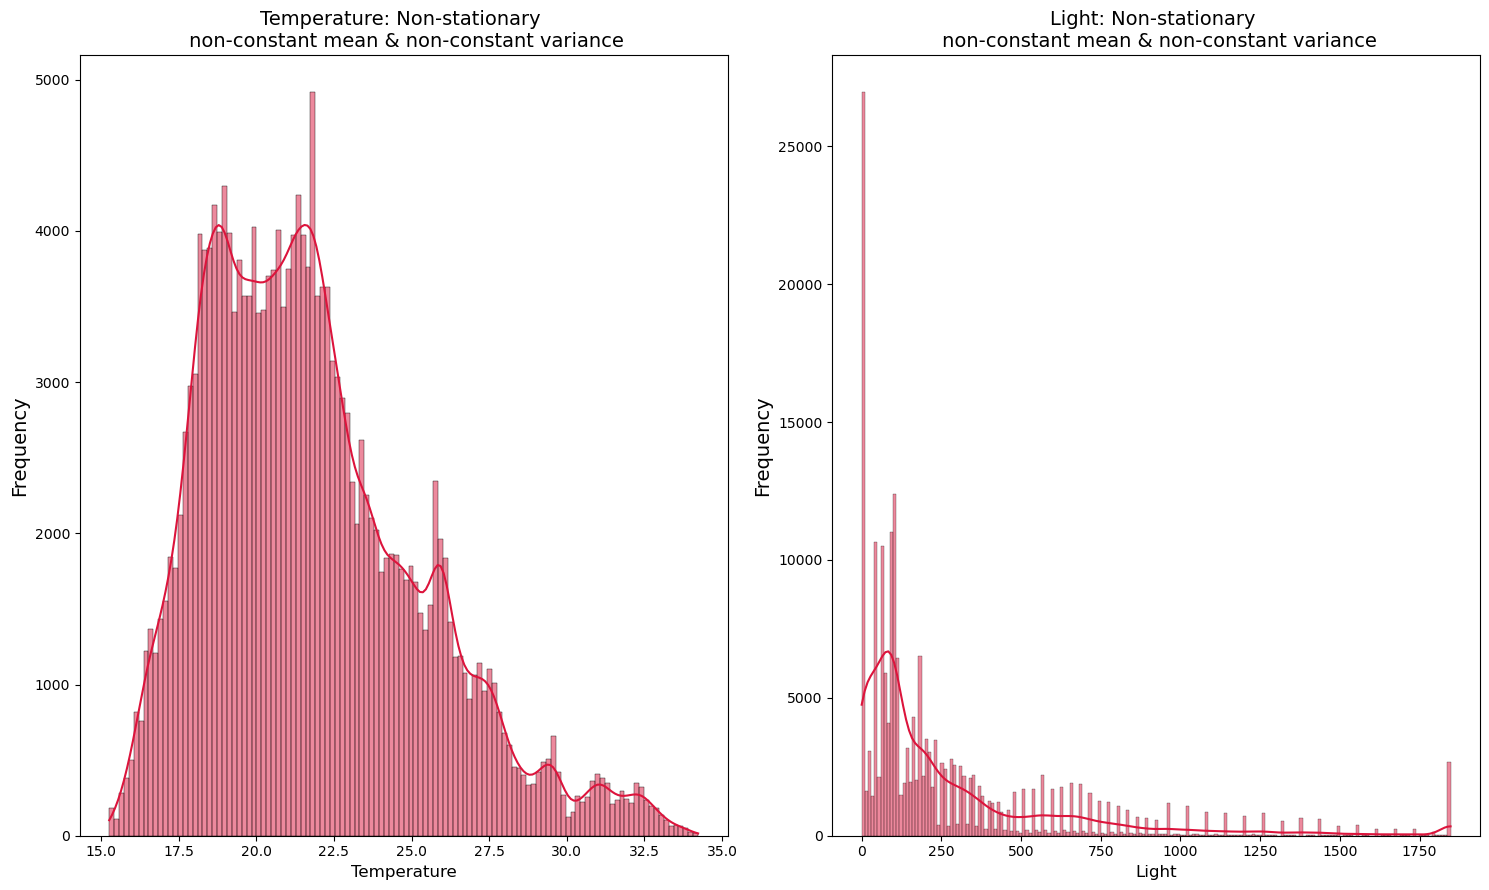

In [23]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 9))
#colors= mediumseagreen,'royalblue','darkorange','purple','crimson',"teal","forestgreen",dodgerblue","lightblue","skyblue"

sns.histplot(clean_data.temperature, ax=ax[0], color="crimson", kde=True)
ax[0].set_title("Temperature: Non-stationary \n non-constant mean & non-constant variance", fontsize=14)
ax[0].set_ylabel("Frequency", fontsize=14)
ax[0].set_xlabel("Temperature", fontsize=12)

sns.histplot(clean_data.light, ax=ax[1], color="crimson", kde=True)
ax[1].set_title("Light: Non-stationary \n non-constant mean & non-constant variance", fontsize=14)
ax[1].set_ylabel("Frequency", fontsize=14)
ax[1].set_xlabel("Light", fontsize=12)

plt.tight_layout()
plt.show()

As seen in the preceeding figure, the data is not stationary and needs to be transformed. 
To do this we use Differencing -subtracts the current value from previous value

Differencing can be done in different orders:

- First order differencing: linear trends with  zi= yi−yi−1
 
- Second-order differencing: quadratic trends with  zi=(yi−yi−1)−(yi−1−yi−2)



In [24]:
# First Order Differencing
ts_diff = np.diff(clean_data.temperature)
clean_data["temperature_diff_1"] = np.append([0], ts_diff)
# Second Order Differencing
ts_diff = np.diff(clean_data.temperature_diff_1)
clean_data["temperature_diff_2"] = np.append([0], ts_diff)


ts_diff = np.diff(clean_data.light)
clean_data["light_diff_1"] = np.append([0], ts_diff)
ts_diff = np.diff(clean_data.light_diff_1)
clean_data["light_diff_2"] = np.append([0], ts_diff)

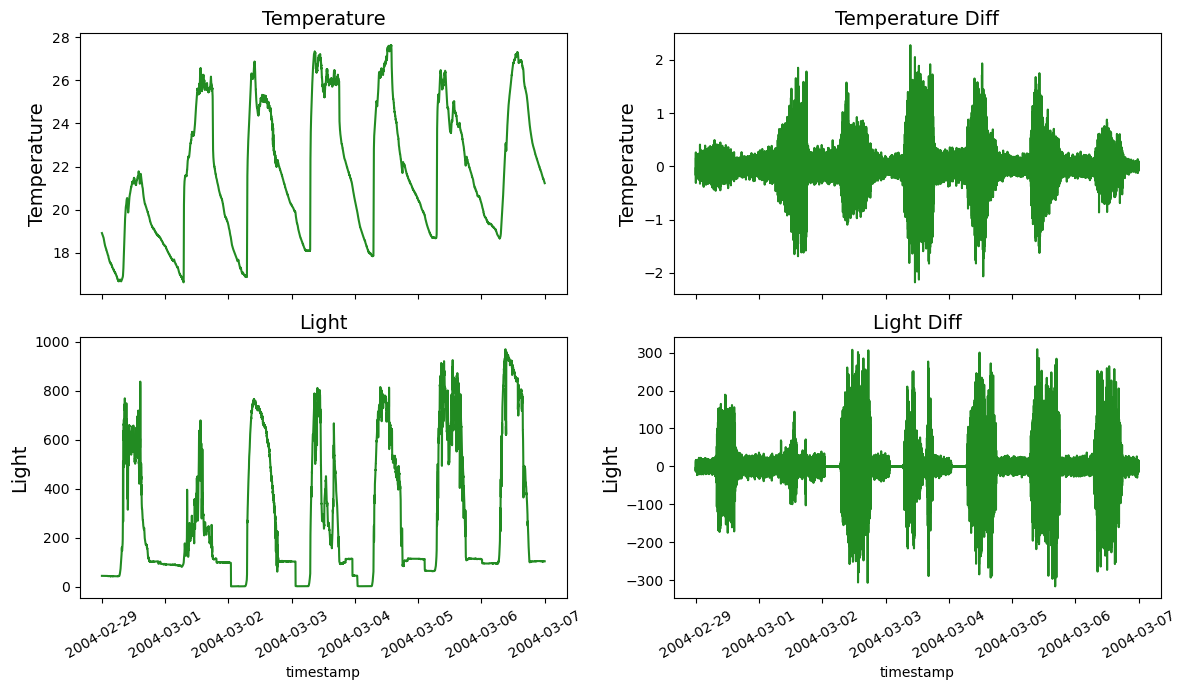

In [25]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12, 7), sharex=True)
ax = ax.flatten()

sns.lineplot(x=clean_data.timestamp, y=clean_data.temperature, ax=ax[0], color="forestgreen", ci=None)
ax[0].set_title("Temperature", fontsize=14)
ax[0].set_ylabel("Temperature", fontsize=14)

sns.lineplot(x=clean_data.timestamp, y=clean_data.temperature_diff_2, ax=ax[1], color="forestgreen", ci=None)
ax[1].set_title("Temperature Diff", fontsize=14)
ax[1].set_ylabel("Temperature", fontsize=14)

sns.lineplot(x=clean_data.timestamp, y=clean_data.light, ax=ax[2], color="forestgreen", ci=None)
ax[2].set_title("Light", fontsize=14)
ax[2].set_ylabel("Light", fontsize=14)

sns.lineplot(x=clean_data.timestamp, y=clean_data.light_diff_2, ax=ax[3], color="forestgreen", ci=None)
ax[3].set_title("Light Diff", fontsize=14)
ax[3].set_ylabel("Light", fontsize=14)

for a in ax:
    for label in a.get_xticklabels():
        label.set_rotation(30)
        
plt.tight_layout()
plt.show()


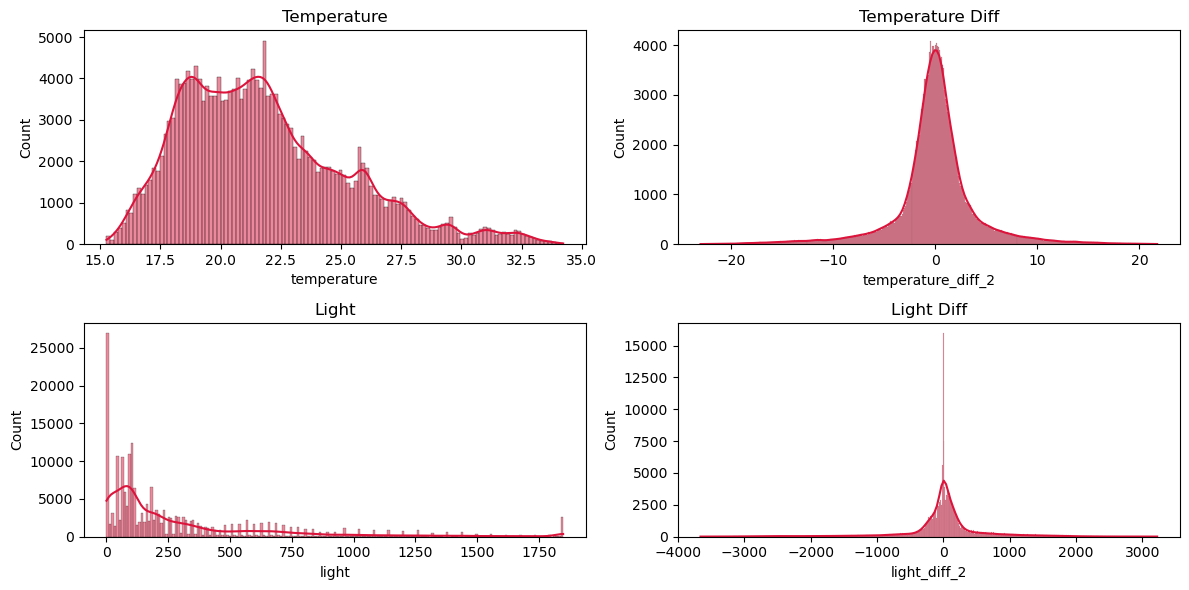

In [26]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12, 6))
ax= ax.flatten()
sns.histplot(clean_data.temperature, ax=ax[0], color="crimson", kde=True)
ax[0].set_title("Temperature", fontsize=12)
sns.histplot(clean_data.temperature_diff_2, ax=ax[1], color="crimson", kde=True)
ax[1].set_title("Temperature Diff", fontsize=12)

sns.histplot(clean_data.light, ax=ax[2], color="crimson", kde=True)
ax[2].set_title("Light", fontsize=12)
sns.histplot(clean_data.light_diff_2, ax=ax[3], color="crimson", kde=True)
ax[3].set_title("Light Diff", fontsize=12)

plt.tight_layout()
plt.show()

## Feature Engineering

In [27]:
# set the 'timestamp' as  the dataframe index
clean_data.set_index("timestamp", inplace=True)

In [28]:
# Time feature Engineering
clean_data["hour"] = clean_data.index.hour
clean_data["Day_of_the_week"] = clean_data.index.dayofweek


hours_in_a_day = 24
clean_data["hour_sin"] = np.sin(2*np.pi* clean_data.hour/hours_in_a_day)
clean_data["hour_cos"] = np.cos(2*np.pi* clean_data.hour/hours_in_a_day)

days_in_a_week = 7
clean_data["Day_of_the_week_sin"] = np.sin(2*np.pi*clean_data.Day_of_the_week/ days_in_a_week)
clean_data["Day_of_the_week_cos"] = np.cos(2*np.pi*clean_data.Day_of_the_week/ days_in_a_week)


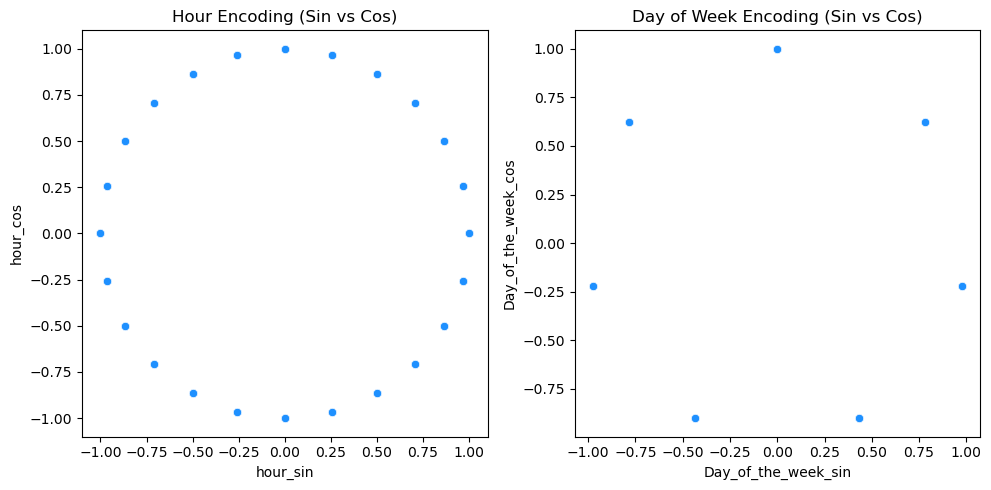

In [29]:
# Cyclic feature encoding
f, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
sns.scatterplot(x=clean_data.hour_sin, y=clean_data.hour_cos, ax=ax[0], color="dodgerblue")
ax[0].set_title("Hour Encoding (Sin vs Cos)")

sns.scatterplot(x=clean_data.Day_of_the_week_sin, y=clean_data.Day_of_the_week_cos, ax=ax[1], color="dodgerblue")
ax[1].set_title("Day of Week Encoding (Sin vs Cos)")
plt.tight_layout()
plt.show()

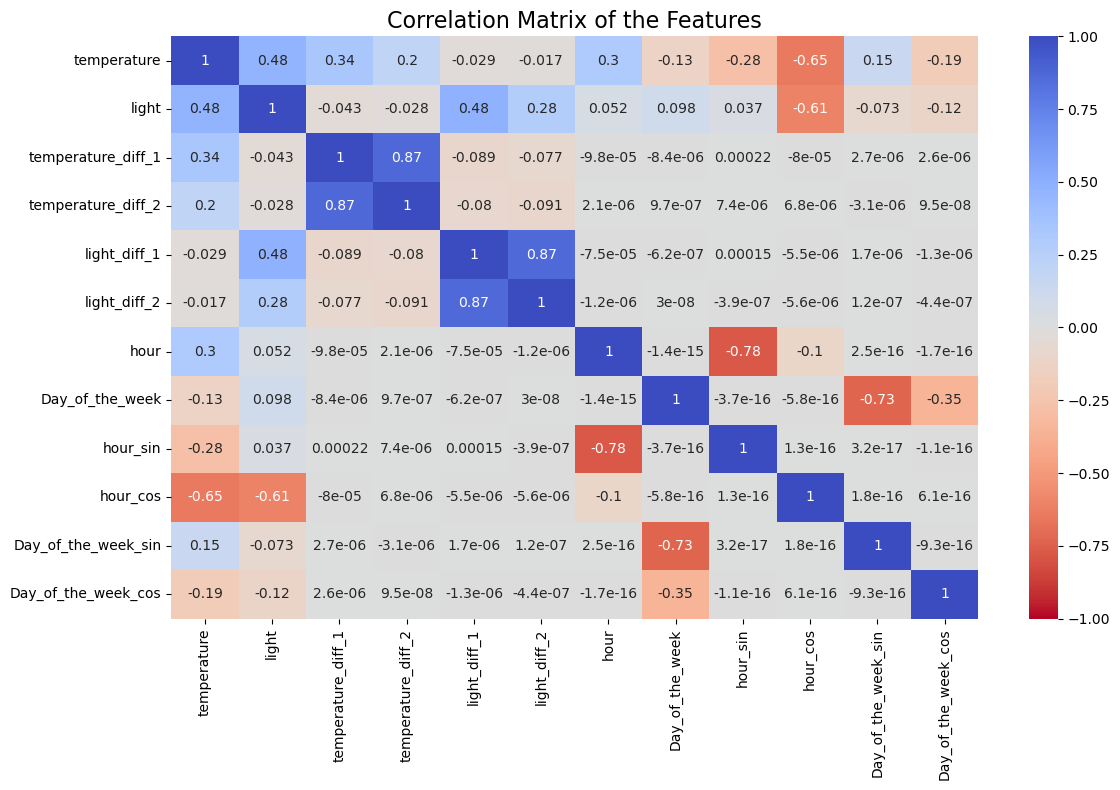

In [30]:
# correlation matrix
f, ax = plt.subplots(figsize=(12, 8))

# columns = ["temperature_diff_2", "light_diff_2", "hour_sin","hour_cos", 
#          "Day_of_the_week_sin","Day_of_the_week_cos"]

corrmat = clean_data.corr()

sns.heatmap(corrmat, annot=True, vmin=-1, vmax=1, cmap="coolwarm_r", ax=ax)
ax.set_title("Correlation Matrix of the Features", fontsize=16)


plt.tight_layout()
plt.show()

In [31]:
target = "temperature_diff_2"
corrmat_sorted = corrmat[[target]].sort_values(by=target, ascending=False)
print(corrmat_sorted)

                     temperature_diff_2
temperature_diff_2         1.000000e+00
temperature_diff_1         8.674373e-01
temperature                1.963550e-01
hour_sin                   7.360633e-06
hour_cos                   6.782814e-06
hour                       2.074826e-06
Day_of_the_week            9.722178e-07
Day_of_the_week_cos        9.466645e-08
Day_of_the_week_sin       -3.149822e-06
light                     -2.764062e-02
light_diff_1              -8.008165e-02
light_diff_2              -9.063963e-02


In [32]:
# Selected features
pred_data = clean_data[["temperature_diff_2", "hour_sin","hour_cos"]]

In [33]:
# Turning the dataset into sequence array appropriate for time-forecasting
window_size = config["window_size"]
X, y = create_sequence(pred_data, window_size, label_column=0)
y = y.reshape(-1, 1)
X.shape, y.shape

((201595, 5, 3), (201595, 1))

In [34]:
split_idx_train = int(len(X) * 0.8)
split_idx_val = int(len(X) * 0.9)

X_train = X[:split_idx_train]
X_val = X[split_idx_train:split_idx_val]
X_test = X[split_idx_val:]

y_train = y[:split_idx_train]
y_val = y[split_idx_train:split_idx_val]
y_test = y[split_idx_val:]


X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((161276, 5, 3),
 (161276, 1),
 (20159, 5, 3),
 (20159, 1),
 (20160, 5, 3),
 (20160, 1))

In [35]:
# MinMax Scalling 
scaler_X = MinMaxScaler(feature_range=(-1,1))

# Reshape X_train for fitting: Flatten (samples * timesteps) into rows, features into columns
X_train_reshaped = X_train.reshape(-1, X_train.shape[-1])

#  scaler for the fearures
scaler_X.fit(X_train_reshaped)


X_train = scaler_X.transform(X_train_reshaped).reshape(X_train.shape)
X_val = scaler_X.transform(X_val.reshape(-1, X_val.shape[-1])).reshape(X_val.shape)
X_test = scaler_X.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

# Scaler for y value
scaler_y = MinMaxScaler(feature_range=(-1,1))

scaler_y.fit(y_train)

y_train = scaler_y.transform(y_train)
y_val = scaler_y.transform(y_val)
y_test = scaler_y.transform(y_test)


In [36]:
# Verifying scalling works properly
print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)
print("X_test shape:", X_test.shape)

print("\nMin/Max of the first feature in X_train:")
print("Min:", X_train[:, 0, 0].min())
print("Max:", X_train[:, 0, 0].max())


print("\ny_train shape:", y_train.shape)
print("y_val shape:", y_val.shape)
print("y_test shape:", y_test.shape)

print("\nMin/Max of first point y_train:")
print("Min:", y_train[:, 0].min())
print("Max:", y_train[:, 0].max())


X_train shape: (161276, 5, 3)
X_val shape: (20159, 5, 3)
X_test shape: (20160, 5, 3)

Min/Max of the first feature in X_train:
Min: -1.0
Max: 1.0000000000000002

y_train shape: (161276, 1)
y_val shape: (20159, 1)
y_test shape: (20160, 1)

Min/Max of first point y_train:
Min: -1.0
Max: 1.0000000000000002


In [37]:
# saving
np.save(config["pred_X_train_path"], X_train)
np.save(config["pred_y_train_path"], y_train)

np.save(config["pred_X_val_path"], X_val)
np.save(config["pred_y_val_path"], y_val)

np.save(config["pred_X_test_path"], X_test)
np.save(config["pred_y_test_path"], y_test)

# EDA, Preprocessing and Feature Engineering for the CNN-MLP System Data

In [38]:
merged_data = merge_dataset(data)
merged_data.shape[0]

1814400

In [39]:
merged_data.head()

,timestamp,mote_id,has_fault_type,temperature,light
0,2004-02-29 00:00:00,1,0,19.2600,45.08
1,2004-02-29 00:00:30,1,0,19.2500,45.08
2,2004-02-29 00:01:00,1,0,19.2500,45.08
3,2004-02-29 00:01:30,1,0,19.2436,45.08
4,2004-02-29 00:02:00,1,0,19.2400,45.08


In [40]:
cls_data = merged_data.drop(["timestamp", "mote_id", "light"], axis=1)

In [41]:
cls_data.isna().sum()

has_fault_type    0
temperature       0
dtype: int64

In [42]:
print(cls_data.duplicated().sum())
cls_data[cls_data.duplicated()].head(10)

1738124


,has_fault_type,temperature
2,0,19.2500
14,0,19.1848
15,0,19.1800
16,0,19.1848
17,0,19.1750
21,0,19.1554
27,0,19.1260
28,0,19.1300
29,0,19.1300
31,0,19.1358


In [43]:
cls_data["has_fault_type"].unique()
# 0 ==> no fault, 4 ==> bias, 8 ==> drift, 16 ==> poly drift,  1 ==> random

array([ 0,  4,  8, 16,  1], dtype=int64)

In [44]:
# re-numbering the 'has_fault_type' column
mapping = {0: 0, 1: 1, 4: 2, 8: 3, 16: 4}
cls_data["has_fault_type"] = cls_data["has_fault_type"].map(mapping)

In [45]:
cls_data["has_fault_type"].unique()
# 0 ==> no fault, 2 ==> bias, 3 ==> drift, 4 ==> poly drift,  1 ==> random

array([0, 2, 3, 4, 1], dtype=int64)

In [46]:
cls_data["has_fault_type"].value_counts()

0    1589887
2      72567
4      69113
3      69112
1      13721
Name: has_fault_type, dtype: int64

In [47]:
cls_data["has_fault_type"].value_counts(normalize=True)

0    0.876260
2    0.039995
4    0.038091
3    0.038091
1    0.007562
Name: has_fault_type, dtype: float64

As seen above, the "*no fault*" class contribules to more that 80% of the data. SMOTE techqune is applied to balance the data

In [48]:
X = cls_data["temperature"].values.reshape(-1, 1)
y = cls_data["has_fault_type"]
y = y.astype(int)

In [49]:
y.dtype

dtype('int32')

In [50]:
# SMOTE
blsmote = BorderlineSMOTE(sampling_strategy="not majority", kind="borderline-1", random_state=42)
X_resampled, y_resampled = blsmote.fit_resample(X, y)
y_resampled.value_counts()

0    1589887
2    1589887
3    1589887
4    1589887
1    1589887
Name: has_fault_type, dtype: int64

In [51]:
# split to train, val, test
# convert this to a numpy array
y_resampled= y_resampled.values

X_train, X_temp, y_train, y_temp = train_test_split(X_resampled, y_resampled, test_size= 0.3,
                                                   stratify=y_resampled, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.33, stratify=y_temp, random_state=42 )

In [52]:
# standardize data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((5564604, 1), (5564604,), (1597836, 1), (1597836,), (786995, 1), (786995,))

In [53]:
y_train = y_train.reshape(-1, 1)
y_val = y_val.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((5564604, 1),
 (5564604, 1),
 (1597836, 1),
 (1597836, 1),
 (786995, 1),
 (786995, 1))

In [54]:
total = len(X_resampled)
print(f"Train: {len(X_train)/total:.2f}")
print(f"Val:   {len(X_val)/total:.2f}")
print(f"Test:  {len(X_test)/total:.2f}")

Train: 0.70
Val:   0.20
Test:  0.10


In [55]:
# saving
np.save(config["cls_X_train_path"], X_train)
np.save(config["cls_y_train_path"], y_train)

np.save(config["cls_X_val_path"], X_val)
np.save(config["cls_y_val_path"], y_val)

np.save(config["cls_X_test_path"], X_test)
np.save(config["cls_y_test_path"], y_test)

Done, for now